In [1]:
import yfinance as yf
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('precision', 2)
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
import math

In [2]:
start = '2020-12-31'
end = '2021-12-31'
jpm = yf.download('JPM', start, end)
wfc = yf.download('WFC', start, end)
bac = yf.download('BAC', start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[0.29594607172474163, 0.6388396202933477, 0.5139179685761484]


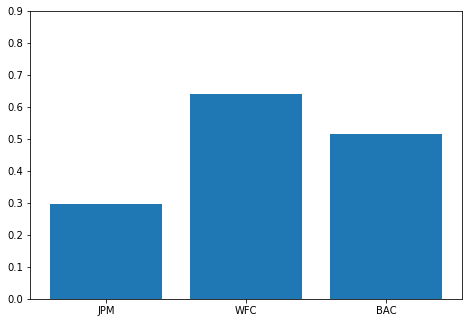

WFC performed the highest with 63.88% gain, followed by BAC with 51.39% and JPM at 29.59%


In [3]:
# Price Performance

jpmchg = (jpm['Adj Close'][-1] - jpm['Adj Close'][0])/jpm['Adj Close'][0]
wfcchg = (wfc['Adj Close'][-1] - wfc['Adj Close'][0])/wfc['Adj Close'][0]
bacchg = (bac['Adj Close'][-1] - bac['Adj Close'][0])/bac['Adj Close'][0]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

chg = [jpmchg, wfcchg, bacchg]
chgnm = ['JPM','WFC','BAC']

print(chg)

ax.bar(chgnm, chg)
ax.set_yticks(np.arange(0, 1, 0.1))

plt.show()

print('WFC performed the highest with 63.88% gain, followed by BAC with 51.39% and JPM at 29.59%')

Visual test between 3 stocks show positive correlation for all 3 possible pairs.


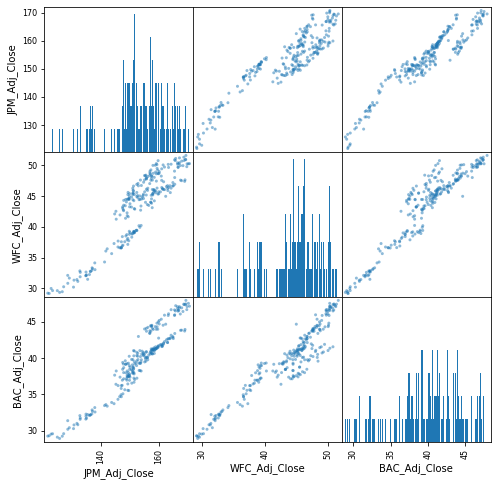

In [4]:
#Scattered Plot Matrix

df = pd.concat([jpm['Adj Close'],wfc['Adj Close'],bac['Adj Close']],axis = 1)
df.columns = ['JPM_Adj_Close','WFC_Adj_Close','BAC_Adj_Close']
scatter_matrix(df, figsize = (8,8), hist_kwds= {'bins':250})

print('Visual test between 3 stocks show positive correlation for all 3 possible pairs.')

In [5]:
# Pearson R
print('JPM and BAC has the highest correlation.\n')
def PearR(a,b):
    corr = a.corr(b)
    if abs(corr) >= 0.8:
        print('Pearson R Correlation: ' + str(corr))
        print('Strong correlation')
    elif abs(corr) >= 0.5:
        print('Pearson R Correlation: ' + str(corr))
        print('Mild correlation')
    else:
        print('Pearson R Correlation: ' + str(corr))
        print('Weak to no correlation')
    print('')
        
PearR(df['JPM_Adj_Close'],df['WFC_Adj_Close'])
PearR(df['JPM_Adj_Close'],df['BAC_Adj_Close'])
PearR(df['BAC_Adj_Close'],df['WFC_Adj_Close'])

JPM and BAC has the highest correlation.

Pearson R Correlation: 0.9127852961359679
Strong correlation

Pearson R Correlation: 0.9502367342849755
Strong correlation

Pearson R Correlation: 0.939799552273613
Strong correlation



In [6]:
#Cointegration

print('JPM and BAC pair is cointegrated.\n')
def cointegration(a, b):
    if coint(a, b)[1] < 0.10:
        print('The series are cointegrated')
        print('p-value = ', coint(a, b)[1])
    else:
        print('The series are NOT cointegrated')
        print('p-value = ', coint(a, b)[1])
    print('')
        
cointegration(df['JPM_Adj_Close'], df['BAC_Adj_Close'])
cointegration(df['WFC_Adj_Close'], df['BAC_Adj_Close'])
cointegration(df['JPM_Adj_Close'], df['WFC_Adj_Close'])

JPM and BAC pair is cointegrated.

The series are cointegrated
p-value =  0.09308319079841937

The series are NOT cointegrated
p-value =  0.21292515247272276

The series are NOT cointegrated
p-value =  0.13004290095658833



In [7]:
# Stationarity

def stationarity(a, cutoff = 0.10):
    a = np.ravel(a)
    if adfuller(a)[1] < cutoff:
        print('The series is stationary')
        print('p-value = ', adfuller(a)[1])
    else:
        print('The series is NOT stationary')
        print('p-value = ', adfuller(a)[1])
    print('')

print('Test statistic for JPM is signficantly higher than critical value, hence stationary.\n')

stationarity(wfc['Adj Close'])
stationarity(bac['Adj Close'])
stationarity(jpm['Adj Close'])

Test statistic for JPM is signficantly higher than critical value, hence stationary.

The series is NOT stationary
p-value =  0.16402419332266144

The series is NOT stationary
p-value =  0.24889174531245511

The series is stationary
p-value =  0.03231498279906487



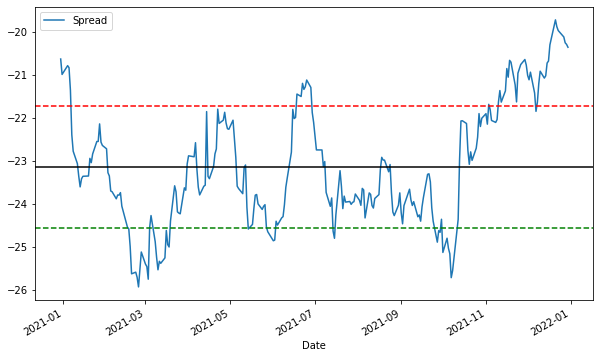

In [8]:
# Spread

S1 = df['JPM_Adj_Close']
S2 = df['BAC_Adj_Close']

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['JPM_Adj_Close']
b = results.params['JPM_Adj_Close']

spread = S2 - b * S1
plt.figure(figsize=(10,6))
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);
plt.axhline(spread.mean() + np.std(spread), color='red', linestyle='--')
plt.axhline(spread.mean() - np.std(spread), color='green', linestyle='--')

When z_s = -1, buy the spread. Unwind at z_s = 0
When z_s = +1, short-sell the spread. Unwind at z_s = 0


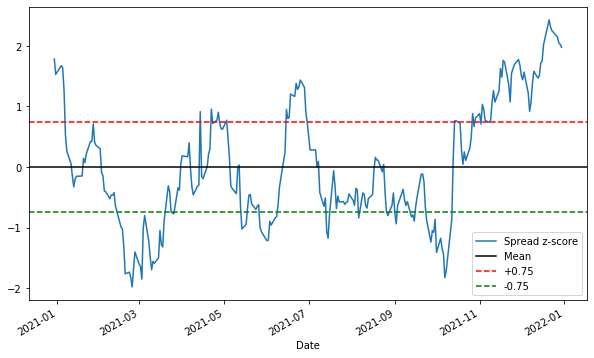

In [9]:
# Z Score on Spread

def zscore(series):
    return (series - series.mean()) / np.std(series)
upper_b = 0.75
lower_b = - 1*upper_b

plt.figure(figsize=(10,6))
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(upper_b, color='red', linestyle='--')
plt.axhline(lower_b, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+'+str(upper_b),'-'+str(upper_b)]);

print('When z_s = -1, buy the spread. Unwind at z_s = 0')
print('When z_s = +1, short-sell the spread. Unwind at z_s = 0')

In [10]:
# Entries and Exits

df['Spread'] = zscore(spread)
df['Buy'] = 0
df['Close_Buy'] = 0
df['Sell'] = 0
df['Close_Sell'] = 0

for i in range(len(df.index)-1):
    if df['Spread'][i] < upper_b and df['Spread'][i+1] >= upper_b and df['Sell'].sum() <= df['Close_Sell'].sum():
        df['Sell'][i] += 1
    elif df['Spread'][i] > 0 and df['Spread'][i+1] <= 0:
        if df['Sell'].sum() - df['Close_Sell'].sum() == 1:
            df['Close_Sell'][i] += 1
    elif df['Spread'][i] > lower_b and df['Spread'][i+1] <= lower_b and df['Buy'].sum() <= df['Close_Buy'].sum():
        df['Buy'][i] += 1
    elif df['Spread'][i] < 0 and df['Spread'][i+1] >= 0:
        if df['Buy'].sum() - df['Close_Buy'].sum() == 1:
            df['Close_Buy'][i] += 1

df2 = df.query('Buy > 0 or Sell > 0 or Close_Buy > 0 or Close_Sell > 0')
df3 = df2.drop(columns=['WFC_Adj_Close','Spread'])
df3

,JPM_Adj_Close,BAC_Adj_Close,Buy,Close_Buy,Sell,Close_Sell
Date,,,,,,
2021-02-12,137.96,32.58,1,0,0,0
2021-03-30,150.88,38.26,0,1,0,0
2021-04-13,151.38,38.58,0,0,1,0
2021-04-14,148.55,39.13,0,0,0,1
2021-04-21,147.89,37.99,0,0,1,0
2021-05-05,154.75,40.61,0,0,0,1
2021-05-13,158.66,41.05,1,0,0,0
2021-06-11,157.47,41.25,0,1,0,0
2021-06-14,154.80,40.75,0,0,1,0


In [11]:
# Arbitrage Table

df4 = df3.drop(columns=['JPM_Adj_Close','BAC_Adj_Close','Buy','Sell','Close_Buy','Close_Sell'])
df4['Step'] = -1
df4['JPM'] = ''
df4['BAC'] = ''
gain = int(10000 * abs(np.std(spread) / spread.mean())) / 100
df4['% Gain'] = ''
df4['$ Gain'] = 0
df4['PnL'] = 0

cap = input('Input your capital here: ')
cap.split(' ')
df4['Port'] = int(cap)
order = str(int(cap)/2)
port = 0

for i in range(len(df3['Buy'])):
    if df3['Close_Buy'][i] == 1 or df3['Close_Sell'][i] == 1:
        df4['% Gain'][i] += str(gain)
        df4['$ Gain'][i] += df4['Port'][i] * gain / 100
        port += df4['$ Gain'][i]
        df4['PnL'][i:] += port
        df4['Port'][i:] += port

    if df3['Buy'][i] == 1:
        df4['JPM'][i] += 'Buy Long ' + str(df4['Port'][i-1]/2)
        df4['BAC'][i] += 'Sell Short ' + str(df4['Port'][i-1]/2)

    elif df3['Close_Buy'][i] == 1:
        df4['JPM'][i] += 'Close Long ' + str(df4['Port'][i-1]/2)
        df4['BAC'][i] += 'Close Short ' + str(df4['Port'][i-1]/2)
    
    elif df3['Sell'][i] == 1:
        df4['JPM'][i] += 'Sell Short ' + str(df4['Port'][i-1]/2)
        df4['BAC'][i] += 'Buy Long ' + str(df4['Port'][i-1]/2)
    
    elif df3['Close_Sell'][i] == 1:
        df4['JPM'][i] += 'Close Short ' + str(df4['Port'][i-1]/2)
        df4['BAC'][i] += 'Close Long ' + str(df4['Port'][i-1]/2)
    df4['Step'][i:] += 1
df4

Input your capital here: 100000


,Step,JPM,BAC,% Gain,$ Gain,PnL,Port
Date,,,,,,,
2021-02-12,0,Buy Long 50000.0,Sell Short 50000.0,,0,0,100000
2021-03-30,1,Close Long 50000.0,Close Short 50000.0,6.08,6080,6080,106080
2021-04-13,2,Sell Short 53040.0,Buy Long 53040.0,,0,6080,106080
2021-04-14,3,Close Short 53040.0,Close Long 53040.0,6.08,6449,18609,118609
2021-04-21,4,Sell Short 59304.5,Buy Long 59304.5,,0,18609,118609
2021-05-05,5,Close Short 59304.5,Close Long 59304.5,6.08,7211,38349,138349
2021-05-13,6,Buy Long 69174.5,Sell Short 69174.5,,0,38349,138349
2021-06-11,7,Close Long 69174.5,Close Short 69174.5,6.08,8411,66500,166500
2021-06-14,8,Sell Short 83250.0,Buy Long 83250.0,,0,66500,166500


Total $ Profit: 221756


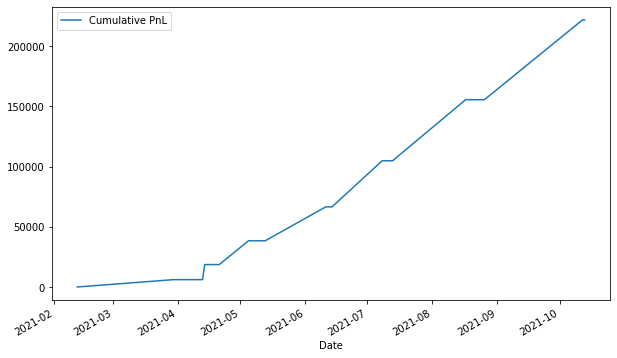

In [12]:
# Cumulative PnL

plt.figure(figsize=(10,6))
df4['PnL'].plot()
plt.legend(['Cumulative PnL']);
print('Total $ Profit: ' + str(df4['PnL'][-1]))